#Errors in serial dilution: How can dispensing technology impact assay data?

####[Sonya M. Hanson and John D. Chodera](http://www.choderalab.org/) Computational Biology Program, Memorial Sloan Kettering Cancer Center, New York NY 10065

In a 2013 paper by Ekins et al, [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325), a surprisingly large discrepancy in IC50 assay results is noted between the assay performed using a **Tecan Genesis** liquid handling workstation compared with a **LabCyte Echo** acoustic dispensing unit.

> *It would appear that tip-based dispensing is producing erroneous data based on our and other analyses which we see here reflected in the models and initial lack of correlations with molecular properties.*

This discrepancy was so large and so surprising that it was quickly picked up and discussed at length by numerous industry blogs, most notabley [In the Pipeline by Derek Lowe](http://pipeline.corante.com/archives/2013/05/03/drug_assay_numbers_all_over_the_place.php), which called the report a "truly disturbing paper".  Speculation abounded as to the precise cause: including sticky compounds, plastic leaching out of pipette tips, colloidal aggregation, miscalibrated pipettes, and sloppy experiments.  But could a simple physical process rooted in the intrinsic variability in the assay explain this difference?

In a biochemical or cell-based assay to determine the potency of a compound of interest, solutions of the compound at several concentrations are prepared and the the assay readout at a number of these concentrations can be fit to yield the $K_i$, IC50, or EC50 (depending on the assay configuration).

With a traditional manual assay or liquid handling workstation (such as the **Tecan Genesis**), the most straightforward approach to preparing a number of these compound concentrations is to prepare a **serial dilution series** starting from an original compound stock solution (often 10 mM stock in DMSO).  In a serial dilution, a volume $V_0$ of one solution is transferred into the next well and diluted with another volume $V_1$ of diluent, allowing a series of solutions spanning orders of magnitude in compound concentration to be prepared in a serial manner.

![alt text](img/serial.png "serial.png")

The **LabCyte Echo**, on the other hand, uses a direct dispensing technology to transfer a programmed volume (from 2.5 nL to microliters) directly into the assay wells, allowing a dilution series over several orders of magnitude in concentration to be created directly without the need for serial dilution.

![alt text](img/direct.png "direct.png")

While the Ekins paper explores the impact assay discrepancies has on QSAR models parameterized to the data, here we focus on the origin of the differences in assay results, and show how a simple model that captures **the errors introduced at each step** of the assay can lead us to identify the culprit behind the large discrepancy between the two assay configurations.  Understanding the origin of this discrepancy---which ends up being a source of bias in one of the assay configurations---can allow us to anticipate assay issues ahead of time, take steps to mitigate them, or even to correct for them after the fact.

Here, we introduce a simple kind of assay modeling in **this IPython notebook** that computational and experimental chemists alike can employ, as a tool that can easily be used to model and understand sources of uncertainty and  biases inherent in any experimental assay.  This kind of modeling could be used, for example, during assay development to ensure that the assay configuration will meet the dynamic range and accuracy needed for the assay, or it could be used after the fact by assay data consumers to understand the expected uncertainty and bias in the experimental dataset.

###First to set up the general python working environment and define our key dataset.

First import a few general packages to be able to deal with numbers (*numpy* and more specificially *numpy.random*) and to allow us to set specific errors between fixed volume values (*scipy.interpolate*).

In [2]:
import numpy as np
from numpy.random import normal
from scipy.interpolate import interp1d

Next import a few packages to allow us to plot (*matplotlib.pyplot*), make nice-looking plots (*seaborn*), and view this plots inside our ipython notebooks (*%pylab inline*).

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_context('talk')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


The dataset we are using to illustrate how to better model and interpret errors comes from the paper mentioned above (  [Dispensing Processes Impact Apparent Biological Activity as Determined by Computational and Statistical Analyses. PLoS ONE 8(5): e62325, 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062325)), some of which was originally described in [a patent from AstraZeneca](http://www.google.com/patents/US7718653). The table in this paper is shown below:

<img src="img/data_combined.png" alt="Drawing" style="width: 800px;"/>

In [4]:
# data from Fig 1 of Ekins et al.
echo_IC50s = np.array([0.064, 0.486, 0.003, 0.002, 0.007, 0.003, 0.004, 0.052, 0.01362, 0.207, 0.158, 0.01164, 0.00633, 0.00358]) * 1e-6 # M
genesis_IC50s = np.array([0.817, 3.03, 0.146, 0.553, 0.973, 0.778, 0.445, 0.17, 0.112, 14.4, 0.25, 0.049, 0.087, 0.152]) * 1e-6 # M

echo_pIC50s = np.log10(echo_IC50s)
genesis_pIC50s = np.log10(genesis_IC50s)

Now if we plot this data to see how the IC50 values obtained with the two different technologies compare to each other, with a line representing if they were identical, we see there are significant discrepencies.

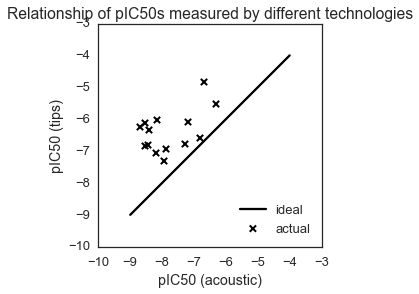

In [5]:
# Plot this data to show the relationship of pIC50's measured by different technologies
plt.subplot(111, aspect='equal');
plt.plot([-9, -4], [-9, -4], 'k-');
plt.scatter(echo_pIC50s, genesis_pIC50s,color='k',marker='x',s=40, linewidth=2);
plt.xlabel('pIC50 (acoustic)');
plt.ylabel('pIC50 (tips)');
plt.legend(['ideal', 'actual'], loc='lower right');
plt.title('Relationship of pIC50s measured by different technologies');

###1. Calculating IC50 for EphB4 system from assay data.

This data is for IC50s of ligands with the enzyme EphB4. From the [EphB4 DataSheet](http://www.proqinase.com/kinase-database/pdfs/2843.pdf), we know the Km for ATP by EphB4 is 1.71 uM . Note that we're assuming that EphB4 obeys Michaelis-Menten kinetics here, and that V0/Vmax is what is measured.

In [6]:
Km = 1.71e-6 # Km of ATP for EphB4 (M)

Let's assume true Ki for an arbitrary compound is 10 nM, a substrate concentration of 4 µM ATP, and that we're using 0.25 ng of ~42.4 kDa enzyme, which gives us 6 µM. We will dispense 2 µL of diluted compound into an assay plate well into which 10 µL of enzyme mix has been dispense.

In [7]:
true_Ki = 10e-9 # arbitrary compound Ki (M)

substrate_concentration = 4e-6 # ATP concentration (M)

enzyme_concentration = 6e-6 # EphB4 assay concentration (M)

#compound_volume = 2.0e-6 # volume of compound dilution added to assay (L)

#mix_volume = 10.0e-6 # volume of enzyme assay mix added to assay (L)

Let's suppose the 10 µL of assay mix in each well was dispensed completely accurately, and contains exact concentrations of enzyme and substrate. We presume inhibition is measured by an exact read of the reaction V0/Vmax.  The IC50 would be the interpolated point at which V0/Vmax drops to 0.5, as determined from a fit of the competitive inhibition equations to the observed V0/Vmax for the dilution series, using the ideal dilution series concentrations in the fit.

We can calculate enzyme activities (V0/Vmax) directly from the values above using the following equation (derived using the assumptions of Michaelis-Menten kinetics for a competitive inhibitor):

$$\frac{V_{0}}{V_{max}} = \frac{[S]}{K_{m}(1+\frac{[I]}{K_{i}})+[S]}$$

In [8]:
#define the function 'competitive_inhibition' using this equation
def competitive_inhibition(substrate_concentration, inhibitor_concentration, enzyme_concentration, Ki, Km):
    V0_over_Vmax = substrate_concentration / (Km*(1 + inhibitor_concentration/Ki) + substrate_concentration)
    return V0_over_Vmax

We have already defined everything in this equation except our inhbitor concentration *[I]*, which is exactly the focus of the later parts of this notebook. Here we will define an ideal dilution series to create our inhibitor concentrations:

![alt text](img/dilution.svg "dilution.svg")

In [14]:
def dilution_series(Vinitial, C0, Vtransfer, Vbuffer, ndilutions):
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    concentrations = numpy.zeros([ndilutions], numpy.float64)
    volumes = numpy.zeros([ndilutions], numpy.float64)
    concentrations[0] = C0
    volumes[0] = Vinitial
    
    # and Vbuffer as initial volume for all but first.
    for n in range(1,ndilutions):
        volumes[n] = Vbuffer
        
    # Create dilution series.
    for n in range(1,ndilutions):
        concentrations[n] = concentrations[n-1] * Vtransfer / (Vtransfer + Vbuffer)
        volumes[n] += Vtransfer
        volumes[n-1] -= Vtransfer
        
    # Remove Vtransfer from last.
    volumes[ndilutions-1] -= Vtransfer
    
    return [volumes, concentrations]

Now, let's use this dilution series to create an 8-point dilution series with an initial concentration of 100 µM, and an initial volume of 100 µL and Vtransfer and Vbuffer = 50 µL.

In [10]:
C0 = 100e-6 # initial dilution concentration (M)

ndilutions = 8 # number of dilutions, including initial dilution

Vinitial = 100e-6 # working volume (L)

Vtransfer = 50e-6 # volume transferred from previous dilution (L)

Vbuffer = 50e-6 # volume of diluent (buffer) added (L)

[assay_volumes, assay_compound_concentrations] = dilution_series(Vinitial, C0, Vtransfer, Vbuffer, ndilutions)

In [11]:
print "Now we have an %s-point dilution series from %f uM to %f uM." % (ndilutions, assay_compound_concentrations.max()/1e-6, assay_compound_concentrations.min()/1e-6)

Now we have an 8-point dilution series from 100.000000 uM to 0.781250 uM.


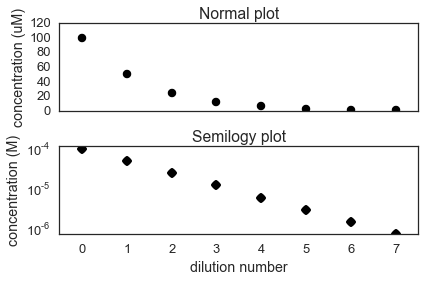

In [13]:
f, (ax1,ax2) = plt.subplots(2,1,sharex=True)

ax1.scatter(range(ndilutions), assay_compound_concentrations/1e-6, lw=4)

ax1.set_title("Normal plot")
ax1.set_ylabel('concentration (uM)')
ax1.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2/1e-6])

ax2.semilogy(range(ndilutions), assay_compound_concentrations,'ko')

ax2.set_title("Semilogy plot")
ax2.set_ylabel('concentration (M)')
ax2.axis([- 0.5, ndilutions - 0.5, 0.0, C0 * 1.2])

plt.xlabel('dilution number')
f.tight_layout()

Now we can use these ideal assay_compound_concentrations to calculate what our activity would be for each inhibitor concentration:

In [12]:
#initialize the activity values with a zero vector
activity = np.zeros([ndilutions], np.float64)

#calclulate activity with our competitive inhibition model and our ideal assay_compound_concentrations
for i in range(ndilutions):
    activity[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)

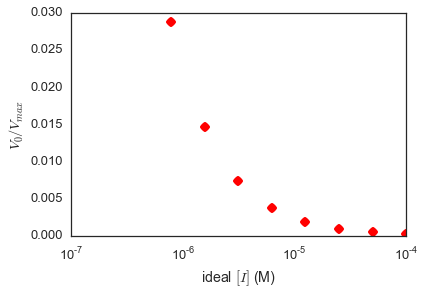

In [13]:
plt.semilogx(assay_compound_concentrations, activity, 'ro');
plt.xlabel('ideal $[I]$ (M)');
plt.ylabel('$V_{0}/V_{max}$');

Of course this is data without error bars, and is not how a real experiment would work. If we assumed both the Genesis (tip-based) and Echo (direct dispensing) methods gave us exactly the right answer for the activity, then these activity values would give us the pIC50 values on the 'ideal' line in the first graph.

###2. Adding the inaccuracy and imprecision of the Tecan Genesis liquid-handling robot.

In reality, every experimental operation---such as a volume transfer---will be imperfect, leading to imperfect assay results.  We can model this---and its often surprising impact on the assay results---by making a simple model for the random and systematic variation with each operation.

Real liquid-handling robots can't transfer the specified volume exactly. Each transfer operation has some (a) inaccuracy (modeled as a constant bias factor for all dispensing operations) and (b) imprecision (random error associated with each volume transfer). It is important to consider these factors separately, as often liquid handlers are callibrated for precision, rather than accuracy, which means bias can creep in. We'll ignore other contributions to error, such as compound stickiness, insolubility, etc. 

![https://en.wikipedia.org/wiki/Accuracy_and_precision](img/accuracy_precision_simple.png "https://en.wikipedia.org/wiki/Accuracy_and_precision")

Suppose we generate this dilution series using a Tecan Genesis robot used in the assay.

Published manufacturer specifications for the imprecision of the Tecan Genesis are available online:

[imprecision data for Tecan Genesis](http://www.frankshospitalworkshop.com/equipment/documents/automated_analyzer/user_manuals/Tecan%20Genesis%20RMP%20-%20User%20manual.pdf)

Tecan does not generally publish inaccuracy specifications, however, since a well-calibrated instrument can essentially eliminate inaccuracy with custom corrections applied to different volume ranges.  In order to illustrate the role inaccuracy can play, we will instead employ inaccuracy data published for a similar class of liquid handling instrument---the Beckman NX/FX span-8:

[inaccuracy/imprecision data for Biomek NX/FX](https://www.beckmancoulter.com/wsrportal/bibliography?docname=BR-10150B.pdf)

![alt text](img/GenesisImprecision.png "GenesisImprecision.png")

First, we define a pipetting error function for the genesis:

In [15]:
def tecan_genesis_pipetting_model(volume):
    # Imprecision from Tecan Genesis manual.
    # Inaccuracy estimated from Beckman Biomek NX/FX span-8.
    
    imprecision_function = interp1d(
        [1.5e-6,100e-6], # volume range (L)
        [0.03, 0.005]) # published relative imprecision for corresponding volumes Tecan Genesis
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6], # volume range (L)
        [0.05, 0.03, 0.03]) # published relative inaccuracies for corresponding volumesfor Beckman NX/FX span-8
    
    return [inaccuracy_function(volume), imprecision_function(volume)]    

Just for reference, this is what the ideal pipetting model looks like in comparison:

In [16]:
def ideal_pipetting_model(volume):

    imprecision_function = interp1d(
        [1.5e-6, 100e-6], # volume range (L)
        [0.0, 0.0]) # relative imprecision for corresponding volumes
    inaccuracy_function = interp1d(
        [0.5e-6, 1e-6, 100e-6], # volume range (L)
        [0.0, 0.0, 0.0]) # relative inaccuracies for corresponding volumes
    
    return [inaccuracy_function(volume), imprecision_function(volume)]

Now consider a single *realization* of the automated pipetting process to generate a dilution series, utilizing the robot pipetting imprecision and inaccuracy model we defined above.

The main difference between our ideal *dilution_series* function here are that we are adding the inaccuracy in the form of the *transfer_bias*, which is a normal distribution around our inaccuracy value, to the *Vbuffer* and *Vtransfer* values. We are also then distributing this value according to a normal distribution around our imprecision value for both the *Vbuffer* and *Vtransfer* values.

In [21]:
def ROBOT_dilution_series(Vinitial, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and Vinitial as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = Vinitial
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilution series.
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
            actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)
        actual_volumes[n] += Vtransfer_actual
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    # Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

In [22]:
[actual_volumes, actual_concentrations] = \
    ROBOT_dilution_series(Vinitial, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)

We can visualize the deviations in concentrations generated by this imprecision and inaccuracy for this single realization.

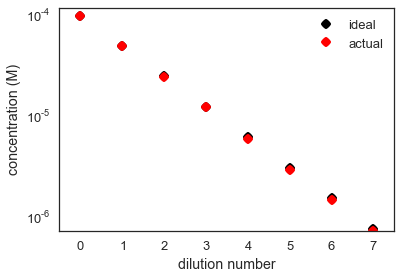

In [25]:
#Set 'ideal_concentrations' and 'ideal_volumes' to the ideal assay_compound_concentrations and assay_volumes from before.
ideal_concentrations = assay_compound_concentrations
ideal_volumes = assay_volumes

plt.semilogy(range(ndilutions), ideal_concentrations, 'ko', range(ndilutions), actual_concentrations, 'ro');
plt.xlabel('dilution number');
plt.ylabel('concentration (M)');
plt.legend(['ideal','actual']);
plt.axis([-0.5, ndilutions - 0.5, 0.0, C0 * 1.2]);

Note the trend that the magnitude of the concentration error increases with subsequent dilutions.  To better see this effect, we plot the relative errors in concentration, volume, and total quantity of compound per well.

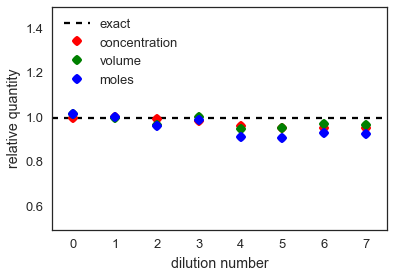

In [26]:
plt.plot([-0.5, ndilutions], [1, 1], 'k--');
plt.plot(range(ndilutions), actual_concentrations / ideal_concentrations, 'ro', \
         range(ndilutions), actual_volumes / ideal_volumes, 'go', \
         range(ndilutions), (actual_volumes*actual_concentrations)/(ideal_volumes*ideal_concentrations), 'bo');
plt.legend(['exact', 'concentration', 'volume', 'moles'], loc='upper left');
plt.axis([-0.5, ndilutions - 0.5, 0.5, 1.5]);
plt.ylabel('relative quantity');
plt.xlabel('dilution number');

Since this was only a single *realization* of the pipetting process, it is difficult to draw conclusions about the *typical* errors in creating a dilution series with a liquid handler.  We can do this by simulating *many* independent realizations of the same experiment, and then estimate the **coefficient of variation (CV)** from the variation among experiments.

So, let's repeat the experiment 5000 times:

In [28]:
nreplicates = 5000

actual_volumes_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)
actual_concentrations_n = numpy.zeros([nreplicates, ndilutions], numpy.float64)

for replicate in range(nreplicates):
    [actual_volumes_replicate, actual_concentrations_replicate] = \
        ROBOT_dilution_series(Vinitial, C0, Vtransfer, Vbuffer, ndilutions, tecan_genesis_pipetting_model)
        
    actual_volumes_n[replicate,:] = actual_volumes_replicate
    actual_concentrations_n[replicate,:] = actual_concentrations_replicate

Now let's use this to compute the CV, using numpy.std, which calculates the standard deviation:

In [29]:
volumes_cv = (actual_volumes_n / ideal_volumes).std(0)
concentrations_cv = (actual_concentrations_n / ideal_concentrations).std(0)
quantity_cv = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).std(0)

Plotting the CV as a function of dilution number reveals surprising trends.

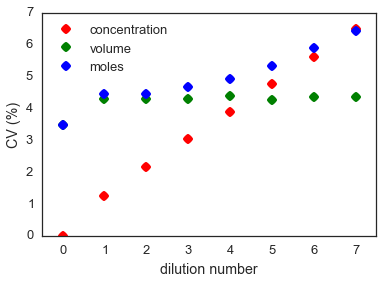

In [30]:
plt.plot(range(ndilutions), concentrations_cv*100, 'ro', \
         range(ndilutions), volumes_cv*100, 'go', \
         range(ndilutions), quantity_cv*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('CV (%)')
plt.xlim([-0.5, ndilutions - 0.5])
plt.legend(['concentration', 'volume', 'moles'], loc='upper left');

While the error in volume is relatively constant with dilution number, the CV (imprecision) in both concentration (molar) and quantity (moles) increases with dilution number: up to 6% in the final sample.

What about bias?  Is there significant deviation from the expected average concentration due to this process?

Let's look at the mean of all these values for this 5000 replicate test.

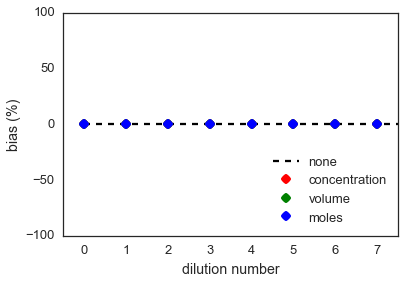

In [31]:
# Compute relative bias.
volumes_bias = (actual_volumes_n / ideal_volumes).mean(0) - 1
concentrations_bias = (actual_concentrations_n / ideal_concentrations).mean(0) - 1
quantity_bias = ((actual_volumes_n * actual_concentrations_n) / (ideal_volumes * ideal_concentrations)).mean(0)- 1

#Let's define DILUTIONS to make plotting easier.
dilutions = numpy.arange(ndilutions)

# Plot relative biases.
plt.plot([0, ndilutions], [0, 0], 'k--', dilutions, concentrations_bias*100, 'ro', \
     dilutions, volumes_bias*100, 'go', dilutions, quantity_bias*100, 'bo')
plt.xlabel('dilution number')
plt.ylabel('bias (%)')
plt.legend(['none','concentration', 'volume', 'moles'], loc='lower right')
plt.axis([-0.5, ndilutions - 0.5, -100, 100]);

We see that the process is essentially free of bias, which is expected if the bias for each realization of the experiment is chosen randomly for this model.  In reality, if multiple experiments are run with the same instrument without recalibration, the same bias in dispensing volumes would lead to biased assay results, but for the purposes of this simulation, we are sampling over many random recalibrations of the same instrument.

Now lets see how our estimation of enzyme activity is affected by including imprecision and inaccuracy.

In [ ]:
def echo_IC50s_function(true_Ki):
    nreplicates = 1000
    IC50s = np.zeros([nreplicates], np.float64)
    for replicate in range(nreplicates):
        [assay_volumes, assay_compound_concentrations] = echo_assay_dispense(C0, mix_volume, backfill_volume, echo_dispense_volumes)
        activities = np.zeros([ndilutions], np.float64)
        for i in range(ndilutions):
            activities[i] = competitive_inhibition(substrate_concentration, assay_compound_concentrations[i], enzyme_concentration, true_Ki, Km)
        IC50s[replicate] = fit_ic50(ideal_concentrations, activities)
    return IC50s

In [ ]:
# Run simulation of many experiments.
pKis = np.array([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3], np.float64);
Kis = 10**pKis
nKis = len(pKis)
echo_pIC50_bias = np.zeros([nKis], np.float64)
echo_pIC50_CV = np.zeros([nKis], np.float64)
for (i, Ki) in enumerate(Kis):
    IC50s = echo_IC50s_function(Ki)    
    pIC50s = np.log10(IC50s)
    pKi = pKis[i]
    echo_pIC50_bias[i] = pIC50s.mean() - pKi;
    echo_pIC50_CV[i] = pIC50s.std() / abs(pIC50s.mean())    

###3. Compare this to inaccuracy and imprecision for LabCyte Echo.

In [ ]:
def echo_assay_dispense(C0, mix_volume, backfill_volume, dispense_volumes):
    inaccuracy = 0.10
    imprecision = 0.08

    ndilutions = len(dispense_volumes)
    echo_volume = numpy.zeros([ndilutions], numpy.float64)
    echo_concentration = numpy.zeros([ndilutions], numpy.float64)
    bias = inaccuracy * normal()
    
    for i in range(ndilutions):
        compound_volume_intended = dispense_volumes[i]
        backfill_volume_intended = backfill_volume - compound_volume_intended
        
        compound_volume_dispensed = compound_volume_intended * ((1+bias) + imprecision*normal())
        backfill_volume_dispensed = backfill_volume_intended * ((1+bias) + imprecision*normal())
        
        echo_volume[i] = mix_volume + backfill_volume_dispensed + compound_volume_dispensed
        echo_concentration[i] = C0 * compound_volume_dispensed / echo_volume[i]

    return [echo_volume, echo_concentration]

###4. Add in dilution effect for Tecan Genesis liquid handler.

In [ ]:
def DILUTE_ROBOT_dilution_series(V0, C0, Vtransfer, Vbuffer, ndilutions, pipetting_model):
    
    # use pipetting error function
    [transfer_inaccuracy, transfer_imprecision] = pipetting_model(Vtransfer)    
            
    # define (b) imprecision of volume transfer operations (including initial volumes)
    transfer_bias = transfer_inaccuracy * normal()
    
    # Initialize concentrations and volumes with zero vectors with C0 and V0 as first value
    actual_concentrations = numpy.zeros([ndilutions], numpy.float64)
    actual_volumes = numpy.zeros([ndilutions], numpy.float64)
    actual_concentrations[0] = C0
    actual_volumes[0] = V0
    
    # and Vbuffer as initial volume for all but first.
    Vbuffer_actual = Vbuffer * ((1+transfer_bias) + transfer_imprecision*normal())
    for n in range(1,ndilutions):
        actual_volumes[n] = Vbuffer_actual
    
    # Create dilute dilution series 
    # Observe only change is in actual_concentrations[n].
    for n in range(1,ndilutions):
        Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
        actual_concentrations[n] = \
             actual_concentrations[n-1] * Vtransfer_actual / (Vtransfer_actual + Vbuffer_actual)\
             * (1+dilution_function(Vtransfer))
        actual_volumes[n] += Vtransfer_actual 
        actual_volumes[n-1] -= Vtransfer_actual
    Vtransfer_actual = Vtransfer * ((1+transfer_bias) + transfer_imprecision*normal())
    
    #Remove Vtransfer from last.
    actual_volumes[ndilutions-1] -= Vtransfer_actual
    
    return [actual_volumes, actual_concentrations]

###5. Now compare Tecan Genesis and LabCyte Echo errors.

In [23]:
# Interpolate bias and CV for Echo and Genesis.
from scipy.interpolate import interp1d
echo_bias_interpolation = interp1d(pKis, echo_pIC50_bias);
echo_CV_interpolation = interp1d(pKis, echo_pIC50_CV);
genesis_bias_interpolation = interp1d(pKis, genesis_pIC50_bias);
genesis_CV_interpolation = interp1d(pKis, genesis_pIC50_CV);

# Compute error bars for Echo and Genesis.
echo_pIC50_err = (echo_CV_interpolation(echo_pIC50s)*numpy.abs(echo_pIC50s))
genesis_pIC50_err = (genesis_CV_interpolation(genesis_pIC50s)*numpy.abs(genesis_pIC50s))

# Plot with error bars.
figure();
subplot(111, aspect='equal');
hold(True);
plot([-9, -4], [-9, -4], 'k-');
errorbar(echo_pIC50s, genesis_pIC50s, xerr=2*echo_pIC50_err, yerr=2*genesis_pIC50_err, fmt='ro');
plot([-9, -6], [-9, -6], 'k-');
xlabel('pIC50 (acoustic)');
ylabel('pIC50 (tips)');
legend(['ideal', 'original'], loc='lower right');
title('95% confidence intervals shown');

NameError: name 'pKis' is not defined

In [42]:
import matplotlib.pyplot as mpld3
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import StaticInteract, RangeWidget, RadioWidget

In [43]:
def slider_plot(error, color):
    fig, ax = sns.plt.subplots(figsize=(5, 5),
                           subplot_kw={'axisbelow':True})
    #ax.grid(color='w', linewidth=2, linestyle='solid')
    ax.plot([-9, -4], [-9, -4], 'k-');
    ax.scatter(echo_pIC50s, genesis_pIC50s - error, color=color,marker='x',s=40, linewidth=2)
    ax.set_xlabel('pIC50 (acoustic)');
    ax.set_ylabel('pIC50 (tips)');
    ax.legend(['ideal', 'actual'], loc='lower right');
    ax.set_title('Relationship of pIC50s measured by different technologies');
    return fig

StaticInteract(slider_plot,
               error=RangeWidget(0.1, 1.0, 0.1),
               color=RadioWidget(['blue', 'green', 'red']))

###6. The HP D300 as an alternative digital dispensing device.